#### Code by: Apurva Umredkar (50592382)


In [30]:
# Importing the libraries
import requests
import zipfile
import io
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import plotly.io as pio
pio.renderers.default='iframe'

import warnings
warnings.filterwarnings("ignore")

In [31]:
# Reading the dataset
gaming_dat = pd.read_csv(r"../data/GamingStudy_data.csv")
# dataset size
gaming_dat.shape, gaming_dat.columns

((13464, 55),
 Index(['S. No.', 'Timestamp', 'GAD1', 'GAD2', 'GAD3', 'GAD4', 'GAD5', 'GAD6',
        'GAD7', 'GADE', 'SWL1', 'SWL2', 'SWL3', 'SWL4', 'SWL5', 'Game',
        'Platform', 'Hours', 'earnings', 'whyplay', 'League', 'highestleague',
        'streams', 'SPIN1', 'SPIN2', 'SPIN3', 'SPIN4', 'SPIN5', 'SPIN6',
        'SPIN7', 'SPIN8', 'SPIN9', 'SPIN10', 'SPIN11', 'SPIN12', 'SPIN13',
        'SPIN14', 'SPIN15', 'SPIN16', 'SPIN17', 'Narcissism', 'Gender', 'Age',
        'Work', 'Degree', 'Birthplace', 'Residence', 'Reference', 'Playstyle',
        'accept', 'GAD_T', 'SWL_T', 'SPIN_T', 'Residence_ISO3',
        'Birthplace_ISO3'],
       dtype='object'))

In [32]:
# data cleaning: S. No. and timestamp are irrelevant, dropping these columns
gaming_dat = gaming_dat.drop(columns = ["S. No.", "Timestamp"], axis = 1)   
gaming_dat.head()

,GAD1,GAD2,GAD3,GAD4,GAD5,GAD6,GAD7,GADE,SWL1,SWL2,...,Birthplace,Residence,Reference,Playstyle,accept,GAD_T,SWL_T,SPIN_T,Residence_ISO3,Birthplace_ISO3
0,0,0,0,0,1,0,0,Not difficult at all,3,5,...,USA,USA,Reddit,Singleplayer,Accept,1,23,5.0,USA,USA
1,1,2,2,2,0,1,0,Somewhat difficult,3,5,...,USA,USA,Reddit,Multiplayer - online - with strangers,Accept,8,16,33.0,USA,USA
2,0,2,2,0,0,3,1,Not difficult at all,2,6,...,Germany,Germany,Reddit,Singleplayer,Accept,8,17,31.0,DEU,DEU
3,0,0,0,0,0,0,0,Not difficult at all,2,5,...,USA,USA,Reddit,Multiplayer - online - with online acquaintanc...,Accept,0,17,11.0,USA,USA
4,2,1,2,2,2,3,2,Very difficult,2,2,...,USA,South Korea,Reddit,Multiplayer - online - with strangers,Accept,14,14,13.0,KOR,USA


Analysis: What are the age of the gamers present in our dataset and what is the mean age?

Mean age of the gamers: 21


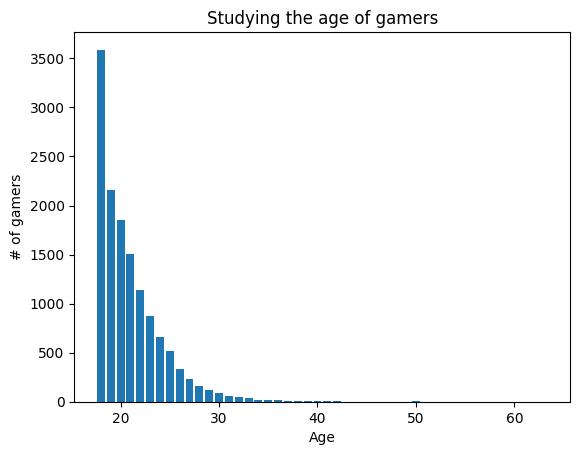

In [33]:
mean_age = np.mean(gaming_dat["Age"])
print(f"Mean age of the gamers: {np.round(mean_age,0):.0f}")

age_count = gaming_dat['Age'].value_counts().reset_index()
plt.bar(age_count["Age"], age_count["count"])
plt.title("Studying the age of gamers")
plt.xlabel("Age")
plt.ylabel("# of gamers")
plt.show()

We can observe that most of the gamers are of the age 18 and the mean age of the gamers in our dataset is 21.

### Hypothesis 1
#### Which country has the highest average of anxiety levels in online gamers?

Approach: The GAD columns contain metrics for General Anxiety Disorder from category 1 to 7. We will take the average of these and group by country, and get the highest and lowest average value.

**A little background on the anxiety terminologies**

In Psychology, General Anxiety Disorder (GAD) has been divided into 7 categories:
1. GAD-1: Feeling nervous, anxious or on edge
2. GAD-2: Not being able to stop or control worrying
3. GAD-3: Worrying too much about different things
4. GAD-4: Trouble relaxing
5. GAD-5: Being so restless that it is hard to sit still
6. GAD-6: Becoming easily annoyed or irritable
7. GAD-7: Feeling afraid as if something awful might happen

The answer to GAD categories can be 0 - Not at all, 1 - Several days, 2 - More than half the days, 3 - Nearly everyday

SWL refers to Satisfaction with Life.

Here, a survey was conducted to curate this dataset which consisted of 5 questions which had to be answered with a SWL score on a scale of 1-5, 1 being Strongly disagree and 5 being Strongly Agree.

In [34]:
# Step 1: Calculate total GAD score per participant
gaming_dat['GAD_total'] = gaming_dat[['GAD1', 'GAD2', 'GAD3', 'GAD4', 'GAD5', 'GAD6', 'GAD7']].sum(axis=1)

# Step 2: Group by country and calculate average GAD score
country_anxiety = gaming_dat.groupby('Residence_ISO3')['GAD_total'].mean()

# Step 3: Sort countries by average GAD score
country_anxiety_sorted = country_anxiety.sort_values(ascending=False).reset_index()

print(f"Based on online gaming data")
print(f"Highest average anxiety: {country_anxiety_sorted.iloc[0,0]} - {country_anxiety_sorted.iloc[0,1]}")
print(f"Lowest average anxiety: {country_anxiety_sorted.iloc[-1,0]} - {country_anxiety_sorted.iloc[-1,1]} ")

Based on online gaming data
Highest average anxiety: QAT - 16.333333333333332
Lowest average anxiety: FJI - 0.0 


Conclusion: Online gamers from Qatar have the highest anxiety levels and gamers from Fiji have the lowest anxiety levels.

But how about the satisfaction with life? Let's implement the same averaging approach but with SWL scores instead.

In [35]:
gaming_dat['SWL_total'] = gaming_dat[['SWL1', 'SWL2', 'SWL5', 'SWL4', 'SWL5']].sum(axis=1)
country_swl = gaming_dat.groupby('Residence_ISO3')['SWL_total'].mean()
country_swl_sorted = country_swl.sort_values(ascending=False).reset_index().rename(columns={"SWL_total": "SWL_avg"})

print(f"Highest SWL average: {country_swl_sorted.iloc[0,0]} - {country_swl_sorted.iloc[0,1]}")
print(f"Highest SWL average: {country_swl_sorted.iloc[-1,0]} - {country_swl_sorted.iloc[-1,1]}")

print(f"Qatar SWL: {country_swl_sorted.loc[country_swl_sorted['Residence_ISO3'] == 'QAT', 'SWL_avg'].values[0]}")
print(f"Fiji SWL: {country_swl_sorted.loc[country_swl_sorted['Residence_ISO3'] == 'FJI', 'SWL_avg'].values[0]}")

Highest SWL average: NAM - 35.0
Highest SWL average: IDN - 8.0
Qatar SWL: 19.666666666666668
Fiji SWL: 12.0


Findings: Namibia has the highest SWL avg, whereas Indonesia has the least SWL average. Even though gamers in Qatar have the highest anxiety disorder, they have a moderate satisfaction with life.

### Hypothesis 2
#### Which age group suffers from the most anxiety?

In [36]:
# Mapping the GAD statement to the corresponding column names in the dataset
gad_statements = {
    'GAD1': 'Feeling nervous, anxious, or on edge',
    'GAD2': 'Not being able to stop or control worrying',
    'GAD3': 'Worrying too much about different things',
    'GAD4': 'Trouble relaxing',
    'GAD5': 'Being so restless that it`s hard to sit still',
    'GAD6': 'Becoming easily annoyed or irritable',
    'GAD7': 'Feeling afraid as if something awful might happen'
}

statement_columns = list(gad_statements.keys())
statement_labels = list(gad_statements.values())

In [37]:
gaming_dat_copy = gaming_dat.copy()

# Creating bins for age
age_bins = [18, 20, 25, 30, 100]
age_labels = ['18-20', '20-25', '25-30', '30+']
gaming_dat_copy['AgeBin'] = pd.cut(gaming_dat_copy.Age, age_bins, labels=age_labels)

# Creating bins for hours played per week
hour_bins = [0, 20, 40, 60, 80, 120]
hour_labels = ['0-20', '20-40', '40-60', '60-80', '80+']
gaming_dat_copy['HoursBin'] = pd.cut(gaming_dat_copy.Hours, hour_bins, labels=hour_labels)

# Prepare data for radar charts
radar_data = gaming_dat_copy.groupby(['AgeBin', 'HoursBin'])[statement_columns].mean().reset_index()

In [38]:
# Create subplots for each age zone
fig = make_subplots(rows=len(age_labels), cols=1,
                    subplot_titles=age_labels,
                    specs=[[{'type': 'polar'}] for _ in age_labels])

# Iterate over each age zone and add radar plot
for idx, age_zone in enumerate(age_labels):
    age_data = radar_data[radar_data['AgeBin'] == age_zone]
    for _, row in age_data.iterrows():
        fig.add_trace(go.Scatterpolar(
            r=row[statement_columns].values,
            theta=statement_labels,
            fill='toself',
            name=f"{row['AgeBin']} | {row['HoursBin']}"
        ), row=idx+1, col=1)

fig.update_layout(
    polar=dict(
        radialaxis=dict(visible=True, showticklabels=False)
    ),
    showlegend=True,
    title="Radar Chart for Psychological Well-being by Age and Hours Played",
    height=2000,
    width=1000
)
fig.show( )
# pyo.iplot(fig)

**Conclusion** \
From the radar charts, it can be seen that young gamers from the age group 18-25 suffer from more anxiety in all areas.

Age group 18-20 & 21-25 is mostly easily annoyed or irritated (GAD-6) \
Age group 25-30 is mostly restless and find it hard to sit still (GAD-5) \
Ages 30+ are mostly not able to stop or control worrying (GAD-2)